<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/Art_Generation_with_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Art: Neural Style Transfer

## 1. Packages


In [33]:
# Importing relevant packages
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.pyplot as imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
from io import BytesIO
import requests
%matplotlib inline

In [29]:
def load_image(path, resize=False):
    "Given the path, it loads the image from URL path"
    r = requests.get(path)
    with BytesIO(r.content) as f:
        content_image = Image.open(f).convert(mode='RGB')
        if resize:
            content_image = content_image.resize(resize)
    return content_image

## 2. Problem Statement

Nerual Style Transfer (NST) is one of the most fun and interesting optimzation techniques in deep learing. It merges two images, namely a **"content" image (C)** and **"style" image (S)**, to create a **"generated" image (G) **. The generated image G combines the "content" of the image C with the "style" of image S.

In this assignment, we are going to cobine the Louvre museum in Paris (content image, C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/louvre_generated.png?raw=true" style="width:750px;height:200px;">

Let's get started!


## 3. Transfer Learning
Neural Style  Transfer (NST) uses a previously tranied convolution network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

We will be using the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been tranied on the very large ImageNet database, and has learned to recoginze a variety of low level features (at the shallow layers) and high level features (at the deeper layer).

Run the below code to load parameters from the VGG model.

In [24]:
tf.random.set_seed(272) # To be consistent with different tries
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.vgg19.VGG19(include_top=False,
                                        input_shape=(img_size, img_size, 3),
                                        weights='imagenet')
vgg.trainable = False
pp.pprint(vgg)

## 4. Neural Style Transfer (NST)

Next, we will be building the Neural Style Transfer (NST) algorithm in three steps:
- First, we will build the content cost function $J_{content} (C, G)$
- Second, we will build the style cost function $J_{style} (S, G)$
- Finally, we will put it all together to get $J(G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)$. Exciting!

### 4.1 Computing the Content cost

#### 4.1.1 Make Generated Image G Match the Content of Image C

One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, we'll need an understanding of **shallow versus deep layer**:

- The shallow layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
- The deeper layers tend to detect higher-level features such as more complex textures and object classes.

<h3>To choose a "middle" activation layer $a^{[l]}$:</h3>
We need the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. In practice, we'll get the most visually pleasing results if we choose a layer in the **middle** of the network neither too shallow nor to deep. This ensures that the network detecs both higher-level and lower-level features

<h3> To forward propagate image "C":</h3>

- Set the image C as the input to the pretrained VGG network, and forward propagation.

- Let $a^{(C)}$ be the hidden layer activation in the layer we had chosen. (symbolised as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation). This will be an $n_H \times n_W \times n_C$ tensor.

<h3> To forward propagate image "G":</h3>

- Repeat this process with the image G: Set G as the input, and run forward propagation.
- Let $a^{(G)}$ be the corresponding hidden layer activation.

In this running example, the conent image C wil be the picture of the Louvre Museum in Paris.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


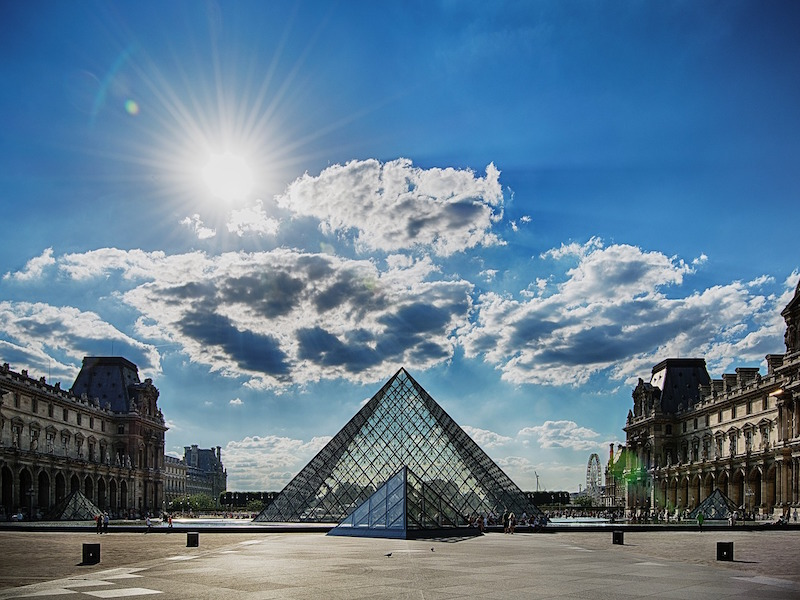

In [30]:
path_to_image = "https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/louvre.jpg?raw=true"
content_image = load_image(path_to_image)
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

### 4.1.2 Content Cost Function $J_{content}(C, G)$
One goal we should aim for when performing NST is for the content of image C. A method this is to calculate the content cost function, which will be defined as:

$$J_{content} (C, G) = \dfrac{1}{4 \times n_H \times n_W \times n_C} \sum_{\text{all entries}} (a^{(c)} - a^{(G)})^2 \tag{1}$$
- Here, $n_H$, $n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost.
- For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activation.
- In order to compute the cost $J_{content} (C, G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix.
- Technically, this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/NST_LOSS.png?raw=true" style="width:800px;height:400px;">

### Compute content cost
 Compute the "content cost" using TensorFlow.

 **Instructions:**

 - `a_G`: hidden layer activation representing content of the image G
 - `a_C`: hidden layer activations representing content of the image C.

 Three steps to implement this function are:
1. Retrieve dimensions from `a_G`:
    - To retrieve dimensions from a tensor `X`, use : `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G` as explained in the picture above
    - We'll likely want to use these function: `tf.response` and `tf.reshape`
3. Compute the content cost:
    - We'll likely want to use these functions: `tf.reduce_sum`, `tf.square` and `tf.subtract`.

<h3> Additional Hints for "Unrolling" </h3>

- To unroll the tensor, we want the shape to change from ($m, n_H, n_w, n_C$) to ($m, n_H \times n_W, n_C$)
- `tf,reshape(tensor, shape)` takes a list of integers that represent the desired output shape.
- For the `shape` parameter, a `-1` tells the function to choose the correct dimension size so that the output tensor still contains all the values of the original tensor.
- So `tf.reshape(a_C, shape=[m, n_H * n_W, n_C]` gives the same result as `tf.reshape[a_C, shape=[m -1, n_C]`.
- If we prefer to re-order the dimensions, we can use `tf.transpose(tensor, perm)`, where `perm` is a list of integers containing the original indes of the dimensions.
- For example, `tf.transpose(a_c, perm=[0,3,1,2])` changes the dimensions form $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.
- Again, not that we'dont necessarily need `tf.transpose` to 'unroll' the tensors in this case but this a useful function to practice and understand for outher situations that we'll encounter.



In [26]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])

    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/ (4* n_H * n_W * n_C)

    return J_content

In [27]:
# TEST: compute_content_cost function
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

print("\033[92mAll tests passed")

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


## 4.2 Compute the Style cost
For running example, we will use the following style image:

In [28]:
path_to_image = "https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/monet_800600.jpg?raw=true"
example = load_image(path_to_image)
example

TypeError: ignored

This was painted in the style of b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how we can now define a "style" cost function $J_{style}(S,G)$!

### 4.2.1 Style Matrix

### Gram matrix
- The style matrix is also called a "Gram matrix"
- In linear algebra, the Gram matrix G of a set of vectors($v_1, v_2, .... , v_n$) is the matrix of dot products whose entries $G_{ij} = v_i^Tv_j = np.dot(v_i, v_j)$.
- In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, we would expect them to have a large dot product, thus for $G_{ij}$ to be large.

### Two meanings of the variable $G$
- Note that there is an unfortunate collision in the variable names used here, Following the common terminology used in the literature:
    - G is used to denote the Style matrix (or Gram matrix)
    - G also denotes the generated image
- For the sake of clarity, in this assignment, $G_{gram}$ will be used to refer to the Gram matrix, and G to denote the generated image.

### Compute the Gram matrix $G_{gram}$
We will compute the style matrix by multiplying the "unrolled" filter matrix with its transpose:
<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/NST_GM.png?raw=true" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

### $G_{(gram)ij}$: correlation
The result is a matrix of dimension ($n_C, n_C$) where $n_C$ is the number of filters (channels). The value $G_{(gram)ij}$ measures how similar the activation of filter $i$ are to the activation of filter $j$.

### $G_{(gram),ii}$: prevalence of patterns or textures
- The diagnoal elements $G_{(gram)ii}$ measures how "active" a filter $i$ is.
- For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common vertical textures are in the image as a whole.
- If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture.

By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ii}$), the style matrix $G_{gram}$ measures the style of an image.

TODO: gram_matrix
- Using TensorFlow, implement a function that computes the Gram matrix of a matrix A
    - The formula is: The gram matrix of A is \begin{equation}G_A= A.A^T \end{equation}
    - Helpful functions: `tf.linalg.matmul` and `tf.transpose`

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.linalg.matmul(A, tf.transpose(A))

    return GA

In [8]:
# TEST gram_matrix function
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


### 4.2 Style Cost

Now we know how to calculate the Gram matrix. Congrats! Our next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G.
- For now, we will use only a single hidden layer $a^{[l]}$.
- The corresponding style cost for this layer is defined as:
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


### compute_layer_style_cost

Compute the style cost for a single layer.

Three steps to implement this function are:
1. Retrieve dimensions from the hidden layer activation `a_G`:
    - To retrieve dimensions from a tensor X, use `X.get_shape().as_list()`
2. Unroll the hidden layre activation `a_S` and `a_G` into 2D matrices, as explained in the picture above (see the images in the section "computing the content cost" and "style matrix").
    - Helpful function: `tf.transpose` and `tf.reshape`
3. Compute the Style matrix of the images S and G.
4. Compute the Style cost:
    - Helpful function: `tf.reduce_sum`, `tf.square` and `tf.subtract`.

**Additional Hints**

- Since the activation dimensions are ($m, n_H, n_W, n_C$) whereas the desired unrolled matrix shape is ($n_C, n_H \times n_W$), the order of the filter dimensions $n_C$ is changed. So `tf.transpose` can be used to change the order of the filter dimension.

In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)

    # Computing the gram matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = (.5 / (n_H * n_W * n_C)) ** 2 * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer

In [10]:
# TEST compute_layer_style_cost function
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_layer_style_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_layer_style_cost\n")
    print(inst)

J_style_layer = tf.Tensor(14.017808, shape=(), dtype=float32)
All tests passed


### 4.2.3 Style Weights
- So far we have captured the style from only one layer
- We'll get better results if we "merge" style cost from several different layers.
- Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
- By default, each layer carries equal weight, and the weights add up to 1. ($\sum_l^l\lambda^{[l]}  = 1$)

In [15]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [16]:

for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Get a look at the output of a layer `block5_conv4`. We will later define this as the content layer, which will represent the image.

In [12]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now, choose layers to represent the style of the image and assign style cost:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

We can combine the style cost for different layers as follows:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.

### compute_style_cost ###
Compute style cost

**Instructions:**
- A compute_style_cost(...) function that has already been implemented
- It calles `compute_layer_style_cost(...)` several times, and weights their result using the values in `STYLE_LAYERS`.

### Description of `compute_style_cost` ###

For each layer:
- Select the activation (the output tensor) of the current layer
- Get the style of the style image "S" from the current layer
- Get the style of the generated image "G" from the current layer
- Compute the "style cost" for the current layer
- Add the weighted style cost to the overall style cost (J_style)

Once, we're done with the loop:
- Return the overall style cost


In [17]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Compute the overall style cost from several chosen layer.

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                    - the names of the layers we would like to extract style from
                    - a coefficient for each of them

    Returns:
    J_sytle -- tensor representing a scalar value, the style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last statement of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style



How do we choose the coeffiecents for each layer? The deeper layer captures higher-level concepts, and the features in the deeper layer are less localized in the image relative to each other. So, if we want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if we want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.

### Points to remember: ###

- The style of an image can be represented using the Gram matrix of a hidden layer's activations.
- We get even better results by combining this representation from multiple different layers.
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image
 to follow the style of the image
.

## 4.3 Defining the Total Cost to Optimize

Finally, we will create a cost function that minimizes both the style and content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

TODO:
Implement the total cost function which includes both the content and the style cost

In [18]:
@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style

    return J

In [19]:
# TEST total_cost function
J_content = 0.2
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


### Points to remember:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

# 5 - Solving the Optimzation problem

Finally, we get to put everything together to implement Neural Style Transfer!

Here's what our program be able to:
1. Load the content image
2. Load the style image
3. Randomly initialize the image to be generated
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

## 5.1 - Load the Content Image

Run the following code cell to load, reshape, and normalize our "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


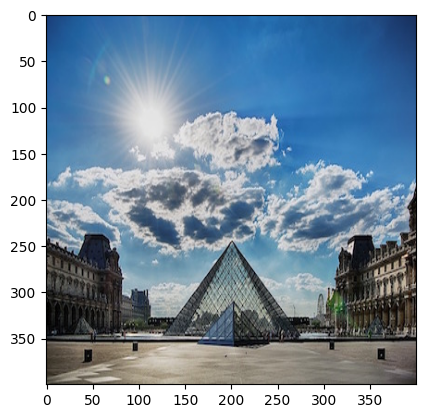

In [35]:
path_to_image = 'https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/louvre_small.jpg?raw=true'
content_image = np.array(load_image(path_to_image, resize=(img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

## 5.2 - Load the Style Image
Now load, reshape and normalize our "style" image (Claude Monet's painting):

(1, 400, 400, 3)


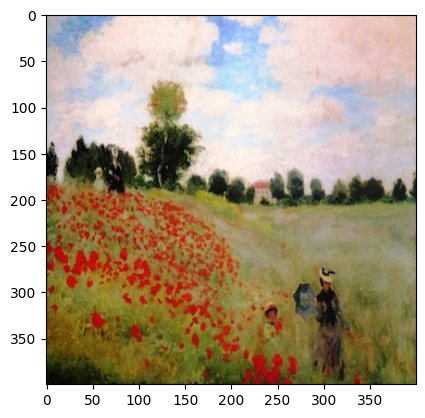

In [37]:
path = 'https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/NerualArtGeneration/images/monet.jpg?raw=true'
style_image = np.array(load_image(path ,resize=(img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1, ) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

## 5.3 - Randomly Initialize the Image to be Generated
 Now, we get to initialize the "generated" image as a noisy image created from the content_image.
 - The generated image is slightly correlated with the content image.
 - By initializing the pixels of the generated image to be most noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.


(1, 400, 400, 3)


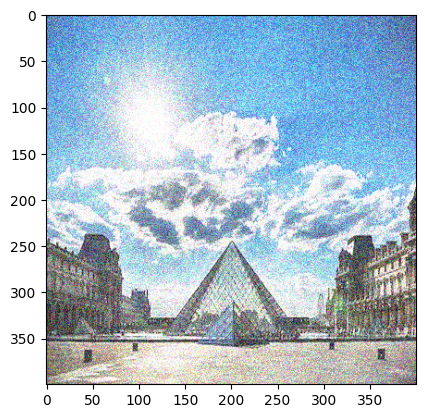

In [38]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

## 5.4 - Load the pre-trained VGG19 Model

Define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [44]:
def get_layer_outputs(vgg, layer_names):
    "Creates a VGG model that returns a list of intermediate output values."
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model

In [43]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separable variables:

In [45]:
content_target = vgg_model_outputs(content_image)   # Content encoder
style_target = vgg_model_outputs(style_image)       # Style encoder

## 5.5 - Compute Total Cost

### 5.5.1 - Compute Content Cost
We've built the model, and now to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `block5_conv4` to compute the content cost. The code below does the following:
1. Set `a_C` to be the tensor giving the hidden layer activation for layer `block5_conv4`.
2. Set `a_G` to be the tensor giving the hidden layer activation for the same layer.
3. Compute the content cost using `a_C` and `a_G`.